In [3]:
import pandas as pd
import numpy as np
import csv
import matplotlib
import matplotlib.pyplot as plt 
import statsmodels.api as sm

from sklearn import preprocessing
from sklearn.feature_selection import chi2
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix

## Python Coding and Data Set

# Load data and col names
data_df = pd.read_csv('data/breast-cancer.csv', header=None)
cols_df = pd.read_csv('data/field_names.txt', header=None)

# Construct col mapping dictionary and rename the columns
col_dict = {data_col: map_col[0] for data_col, map_col in zip(data_df.columns, cols_df.values)}
data_df = data_df.rename(index=str, columns=col_dict)

# Check data format
data_df.describe()

,ID,radius_mean,radius_sd_error,radius_worst,texture_mean,texture_sd_error,texture_worst,perimeter_mean,perimeter_sd_error,perimeter_worst,...,concavity_worst,concave_points_mean,concave_points_sd_error,concave_points_worst,symmetry_mean,symmetry_sd_error,symmetry_worst,fractal_dimension_mean,fractal_dimension_sd_error,fractal_dimension_worst
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


diagnosis
B    12.146524
M    17.462830
Name: radius_mean, dtype: float64 diagnosis
B    12.200
M    17.325
Name: radius_mean, dtype: float64 diagnosis
B    1.780512
M    3.203971
Name: radius_mean, dtype: float64


"\nThe patients dianogised as benign generally have:\n1. Smaller mean radius than those diagnosed as 'malign'\n2. Smaller median radius than those diagnosed as 'malign'\n3. Smaller standard deviation than those diagnosed as 'malign'\n4. The group diagnosed as B also has smoother histogram\n"

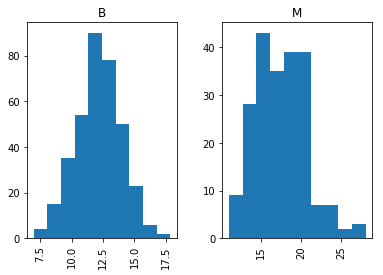

In [4]:
# Compute mean and median smoothness and compactness
mean = data_df.groupby('diagnosis').radius_mean.mean()
median = data_df.groupby('diagnosis').radius_mean.median()
std_dev = data_df.groupby('diagnosis').radius_mean.std()

# Find histogram
data_df['radius_mean'].hist(by=data_df['diagnosis'])


# Check results
print(mean, median, std_dev)

"""
The patients dianogised as benign generally have:
1. Smaller mean radius than those diagnosed as 'malign'
2. Smaller median radius than those diagnosed as 'malign'
3. Smaller standard deviation than those diagnosed as 'malign'
4. The group diagnosed as B also has smoother histogram
"""

In [5]:
# Bootstrap sampling function
def bootstrap(dataframe, samples):
    return dataframe.sample(n=samples)
    
# Test
samples = bootstrap(data_df['radius_mean'], 10)
print(samples)

511    14.81
485    12.45
145    11.90
435    13.98
534    10.96
439    14.02
494    13.16
488    11.68
422    11.61
495    14.87
Name: radius_mean, dtype: float64


In [6]:
## Exploratory Analysis
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 569 entries, 0 to 568
Data columns (total 32 columns):
ID                            569 non-null int64
diagnosis                     569 non-null object
radius_mean                   569 non-null float64
radius_sd_error               569 non-null float64
radius_worst                  569 non-null float64
texture_mean                  569 non-null float64
texture_sd_error              569 non-null float64
texture_worst                 569 non-null float64
perimeter_mean                569 non-null float64
perimeter_sd_error            569 non-null float64
perimeter_worst               569 non-null float64
area_mean                     569 non-null float64
area_sd_error                 569 non-null float64
area_worst                    569 non-null float64
smoothness_mean               569 non-null float64
smoothness_sd_error           569 non-null float64
smoothness_worst              569 non-null float64
compactness_mean              569 no

In [7]:
X = data_df.iloc[:,[i for i in range(2, len(cols_df))]].values
y = data_df.iloc[:,1].values
scores, pvalues = chi2(X, y)
for col, pvalue in zip(cols_df.values[2:], pvalues):
    print(col[0], ': ', pvalue)
    
"""
None of the features are significantly correlated.
"""

radius_mean :  8.013976278328902e-60
radius_sd_error :  3.322921942469559e-22
radius_worst :  0.0
texture_mean :  0.0
texture_sd_error :  0.6986316439643432
texture_worst :  0.020101299869930415
perimeter_mean :  9.001757118104485e-06
perimeter_sd_error :  0.0011656363837254005
perimeter_worst :  0.6119260262217878
area_mean :  0.993122220593947
area_sd_error :  3.895534287116933e-09
area_worst :  0.921168191797168
smoothness_mean :  1.9487748916821694e-56
smoothness_sd_error :  0.0
smoothness_worst :  0.9544251208536502
compactness_mean :  0.43336611540692505
compactness_sd_error :  0.30672681214870445
compactness_worst :  0.580621137019778
concavity_mean :  0.9928474096871704
concavity_sd_error :  0.9363797534759137
concavity_worst :  6.113247507357666e-109
concave_points_mean :  7.896682986754715e-40
concave_points_sd_error :  0.0
concave_points_worst :  0.0
symmetry_mean :  0.5284528674102649
symmetry_sd_error :  1.1083676221329937e-05
symmetry_worst :  3.2523006361423745e-10
fract

'\nNone of the features are significantly correlated.\n'

In [8]:
"""
Modeling
Build a model to predict the malignant tumors.
Use at least two classification techniques; compare and contrast the advantages and disadvantages of each.
Identify how you would control for overfitting in each classification technique.
Evaluate the performance of each model.
In each model, identify the most important predictive variables and explain how you identified them.
"""

# Logistic Regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=25)
LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)
y_pred = LogReg.predict(X_test)

cfm = confusion_matrix(y_test, y_pred)
print(cfm)

"""
The confusion matrix is telling us that 109 and 50 are the number of correct predictions.
"""

[[109   4]
 [  8  50]]


'\nThe confusion matrix is telling us that 109 and 50 are the number of correct predictions.\n'

In [9]:
# Logit Regression
LogReg = LogisticRegressionCV()
LogReg.fit(X_train, y_train)
y_pred_2 = LogReg.predict(X_test)

cfm2 = confusion_matrix(y_test, y_pred_2)
print(cfm2)

"""
The confusion matrix is telling us that 109 and 51 are the number of correct predictions.
"""

[[110   3]
 [  7  51]]


'\nThe confusion matrix is telling us that 109 and 51 are the number of correct predictions.\n'